# Predicting restaurant popularity using Xgboost

### Step 0. Load packages

In [19]:
from __future__ import print_function
import argparse
import json
import pprint
import requests
import sys
import urllib
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import seaborn as sns
import shap

import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('default')

try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode

### Step 1. Data cleaning

Extract the zip code, latitude and longitude from the raw data

In [7]:
df_gentri_raw = pd.read_csv('../data/gentri.csv').drop(['Unnamed: 0'], axis=1)
df_nongen_raw = pd.read_csv('../data/nongen.csv').drop(['Unnamed: 0'], axis=1)
df_overla_raw = pd.read_csv('../data/overlap.csv').drop(['Unnamed: 0'], axis=1)

# zip code
df_gentri_raw['location'] = df_gentri_raw['location'].apply(literal_eval)
df_gentri_raw['zip_code'] = [i.get('zip_code') for i in df_gentri_raw['location']]

df_nongen_raw = df_nongen_raw[df_nongen_raw['rating'] != 0]
df_nongen_raw['location'] = df_nongen_raw['location'].apply(literal_eval)
df_nongen_raw['zip_code'] = [i.get('zip_code') for i in df_nongen_raw['location']]

df_overla_raw['location'] = df_overla_raw['location'].apply(literal_eval)
df_overla_raw['zip_code'] = [i.get('zip_code') for i in df_overla_raw['location']]

# latitude and longitude
df_gentri_raw['coordinates'] = df_gentri_raw['coordinates'].apply(literal_eval)
df_gentri_raw['latitude'] = [i.get('latitude') for i in df_gentri_raw['coordinates']]
df_gentri_raw['longitude'] = [i.get('longitude') for i in df_gentri_raw['coordinates']]

df_nongen_raw['coordinates'] = df_nongen_raw['coordinates'].apply(literal_eval)
df_nongen_raw['latitude'] = [i.get('latitude') for i in df_nongen_raw['coordinates']]
df_nongen_raw['longitude'] = [i.get('longitude') for i in df_nongen_raw['coordinates']]

df_overla_raw['coordinates'] = df_overla_raw['coordinates'].apply(literal_eval)
df_overla_raw['latitude'] = [i.get('latitude') for i in df_overla_raw['coordinates']]
df_overla_raw['longitude'] = [i.get('longitude') for i in df_overla_raw['coordinates']]

Define the popularity index by adjusting the over-high ratings

- For example, if one restaurant is rated as 5-star with only one review, we consider it as an over-rating and downscale it to around 3-star.

In [8]:
# popularity index
change = df_gentri_raw['rating'] > 3
ex = list(map(np.exp, (np.log(df_gentri_raw['review_count']))))
sigm = [(i+8.5)/(i+10) for i in ex]
weight = [sigm[i] if change[i] else 1 for i in df_gentri_raw.index.values]
df_gentri_raw['rating_adj'] = df_gentri_raw['rating'] * weight

change = df_nongen_raw['rating'] > 3
ex = list(map(np.exp, (np.log(df_nongen_raw['review_count']))))
sigm = [(i+8.5)/(i+10) for i in ex]
weight = [sigm[i] if change[i] else 1 for i in df_nongen_raw.index.values]
df_nongen_raw['rating_adj'] = df_nongen_raw['rating'] * weight

change = df_overla_raw['rating'] > 3
ex = list(map(np.exp, (np.log(df_overla_raw['review_count']))))
sigm = [(i+8.5)/(i+10) for i in ex]
weight = [sigm[i] if change[i] else 1 for i in df_overla_raw.index.values]
df_overla_raw['rating_adj'] = df_overla_raw['rating'] * weight

In [9]:
df_gentri = df_gentri_raw[['id','price','zip_code','rating_adj']]
df_nongen = df_nongen_raw[['id','price','zip_code','rating_adj']]
df_overla = df_overla_raw[['id','price','zip_code','rating_adj']]

Merge files: restaurant data, demographic data, and the one-hot encoded restaurant category information

In [10]:
# one-hot encoded category information
catego_gentri = pd.read_csv('../data/gentri_dummy.csv').drop(['Unnamed: 0'], axis=1)
catego_nongen = pd.read_csv('../data/nongen_dummy.csv').drop(['Unnamed: 0'], axis=1)
catego_overla = pd.read_csv('../data/overlap_dummy.csv').drop(['Unnamed: 0'], axis=1)

# demographic information
demo_gentri = pd.read_csv('../data/zip_demo_gentri.csv').drop(['Unnamed: 0'], axis=1)
demo_gentri['ZipCode'] = demo_gentri['ZipCode'].apply(str)
demo_nongen = pd.read_csv('../data/zip_demo_nongen.csv').drop(['Unnamed: 0'], axis=1)
demo_nongen['ZipCode'] = demo_nongen['ZipCode'].apply(str)

# manually matched the restaurants in the overlapped areas
demo_overla = pd.read_csv('../data/overlap_id_demo.csv').drop(['Unnamed: 0'], axis=1)

# merge restaurant data, demographic data, and the category information
df_gentri_all = pd.merge(df_gentri, demo_gentri, how='left', left_on=['zip_code'], right_on = ['ZipCode'])
df_nongen_all = pd.merge(df_nongen, demo_nongen, how='left', left_on=['zip_code'], right_on = ['ZipCode'])
df_overla_all = pd.merge(demo_overla, df_overla, how='left', left_on=['id'], right_on = ['id'])
df_overla_all = df_overla_all.drop_duplicates(subset='id', keep="last")

data_gentri = pd.merge(df_gentri_all, catego_gentri, left_index=True, right_index=True)
data_gentri = data_gentri.drop(['zip_code', 'ZipCode','puma10','puma_id','puma_name','class'], axis=1)
data_nongen = pd.merge(df_nongen_all, catego_nongen, left_index=True, right_index=True)
data_nongen = data_nongen.drop(['zip_code', 'ZipCode','puma10','puma_id','puma_name','class'], axis=1)
data_overla = pd.merge(df_overla_all, catego_overla, left_index=True, right_index=True)

# assign the restaurants in the overlapped areas to gentrifying and non-gentrifying
gentri_add = data_overla[data_overla['class'] == 1]
gentri_add = gentri_add.drop(['zip_code', 'class'], axis=1)
nongen_add = data_overla[data_overla['class'] == 2]
nongen_add = nongen_add.drop(['zip_code', 'class'], axis=1)
frames = [data_gentri, gentri_add]
data_gentri_all = pd.concat(frames).drop(['id'], axis=1)
frames = [data_nongen, nongen_add]
data_nongen_all = pd.concat(frames).drop(['id'], axis=1)

Define the 4 price levels as 'low', 'medium', 'expensive', 'very expensive'

In [11]:
data_gentri_price = data_gentri_all['price']
dummies_gentri = pd.get_dummies(data_gentri_price)
dummies_gentri.columns = ['low', 'medium', 'expensive', 'very expensive']
data_gentri_all = pd.concat([data_gentri_all, dummies_gentri], axis = 1).drop(['price'], axis=1)

data_nongen_price = data_nongen_all['price']
dummies_nongen = pd.get_dummies(data_nongen_price)
dummies_nongen.columns = ['low', 'medium', 'expensive', 'very expensive']
data_nongen_all = pd.concat([data_nongen_all, dummies_nongen], axis = 1).drop(['price'], axis=1)

### Step 2. Model fitting

For each of the gentrifying and non-gentrifying areas:
- First regress the popularity index on the demographic variables to give insights on how to choose the right place
- Then regress the residuals on the restaurant variables to discuss how pricing and service can further add value to the business

#### Step 2.1 Gentrifying areas

In [21]:
X_gentri = data_gentri_all[['pop_pov_u18_pct','pop_pov_65p_pct', 'pop_pov_pct', 'income_diversity_ratio',
       'rent_burden_med', 'pop_commute_time_avg', 'pop_commute_carfree_pct','pop_65p_pct', 'pop_edu_nohs_pct', 
       'pop_edu_collp_pct','pop_discon_youth_pct', 'hh_u18_pct', 'pop_num', 'hh_alone_pct','pop_bornstate_pct', 
       'pop_race_white_pct', 'pop_race_hisp_pct','pop_race_black_pct', 'pop_race_asian_pct', 'pop_race_div_idx',
       'pop_foreign_pct', 'pop_unemp_pct', 'pop_laborforce_pct','m_prox_subway_pct', 'm_crime_viol_rt', 
       'm_crime_prop_rt','m_crime_all_rt']]
y_gentri = data_gentri_all['rating_adj']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_gentri, y_gentri, test_size = 0.2, random_state = 0)

In [22]:
dtrain1 = xgb.DMatrix(data = X_train1, label = y_train1) 
dtest1 = xgb.DMatrix(data = X_test1, label = y_test1)
params = {'learning_rate': 0.1, 'n_estimators': 1000,
          'max_depth': 5, 'min_child_weight': 1,
          'gamma': 0, 
          'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'seed': 0}
cv_result1 = xgb.cv(params, dtrain1, num_boost_round = 1000, nfold = 5,
                   metrics = 'rmse', early_stopping_rounds = 50)
cv_result1.tail()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
126,0.818788,0.048598,0.813449,0.011723
127,0.818668,0.048555,0.813450,0.011721
128,0.818707,0.048575,0.813453,0.011712
129,0.818542,0.048662,0.813460,0.011710
130,0.818487,0.048920,0.813463,0.011713


In [91]:
cv_params_1 = {'max_depth': range(1,7,2),
               'min_child_weight': range(1,7,2),
               'gamma': [0.001, 0.01, 0.1], 
               'subsample': [0.7, 0.8, 0.9], 
               'colsample_bytree': [0.7, 0.8, 0.9]}
params_1 = {'learning_rate': 0.1, 'n_estimators': 150,
            'objective': 'reg:linear', 'random_state': 2}
optimized_GBM_1 = GridSearchCV(estimator = XGBRegressor(**params_1), param_grid = cv_params_1, 
                               scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1, verbose = 10)
optimized_GBM_1.fit(X_train1, y_train1)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.6100145791188701, total=   0.2s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.7167071092627731, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.618617855169259, total=   0.2s
[CV]  colsample_byt

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1992s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.609334857435505, total=   0.2s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.7176118075120659, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.745848868211662, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.6190328711571308, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, m

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.8s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.7167071092627731, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.609334857435505, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.618617855169259, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.745848868211662, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.7452776445786427, total=   0.2s
[

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.6587790552837295, total=   0.2s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.7452776445786427, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7176118075120659, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.6190328711571308, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.745848868211662, total=   0.2s

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.4s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6180142165542023, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.7173129602683022, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.7165336867084855, total=   0.7s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6096187231177835, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6190893955034397, total=   0.8

[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.8s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7165336867084855, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6596333329159914, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.7175400578223912, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6190893955034397, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6185388788818731, total=   0.4

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.0s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6092401190034893, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.7451289966224491, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.6596333329159914, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6603544724043641, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.7175400578223912, total=   0.4

[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    9.4s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7450539899088194, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.6605803134126623, total=   0.5s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.6610294680748776, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7175674094955657, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.6184981303290815, total=   0.5

[Parallel(n_jobs=-1)]: Batch computation too slow (2.0172s.) Setting batch_size=1.


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.7175674094955657, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6184981303290815, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6095517528521727, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6090127506787804, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.7450539899088194, total=   0.6

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   12.5s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6598279490541863, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.7174646799973232, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.7451642471053441, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6189441938578351, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6091930950019105, total=   0.6

[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   14.5s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.618617855169259, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.6587790552837295, total=   0.3s
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.609334857435505, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8 
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.7176118075120659, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.745848868211662, total=   0.2s
[CV] colsa

[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   15.3s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.7167071092627731, total=   0.3s
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.7452776445786427, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.618617855169259, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6587790552837295, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.609334857435505, total=   0.2s
[CV] cols

[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:   16.2s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.7452776445786427, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.618617855169259, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.6587790552837295, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.609334857435505, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7176118075120659, total=   0.3s
[CV] cols

[Parallel(n_jobs=-1)]: Done 179 tasks      | elapsed:   17.1s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6095722570770596, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.7164524670022361, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.7460079002959602, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6190546957171006, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6596144207837001, total=   0.5s
[CV] co

[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   19.3s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7460079002959602, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6190546957171006, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6596144207837001, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6091934282809571, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.7175837618053977, total=   0.4s
[CV] co

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   21.5s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6091934282809571, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.7175837618053977, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.7450919974115772, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6184332028009437, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6607404527526315, total=   0.5s
[CV] co

[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   23.8s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.6605953603408683, total=   0.5s
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.6185145651510372, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.6089686533133672, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7175959888644678, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7449956996807788, total=   0.5s
[CV] co

[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed:   26.9s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.7175959888644678, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.7449956996807788, total=   0.7s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6184340898492107, total=   0.7s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6610657305381047, total=   0.7s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6095247661757202, total=   0.6s
[CV] co

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   30.1s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.7176118075120659, total=   0.2s
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.745848868211662, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.6190328711571308, total=   0.3s
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.659589992604416, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6091179179742771, total=   0.2s
[CV] colsample_byt

[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed:   31.5s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.7173129602683022, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.7448591024190215, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6607040017477843, total=   0.3s
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6180142165542023, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.6100145791188701, total=   0.2s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:   33.1s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6592829486665099, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.6092949725162218, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.7175775078770287, total=   0.4s
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.7449882395898941, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.6185309721540052, total=   0.4s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 339 tasks      | elapsed:   35.7s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6604599449387145, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.6091458836768484, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7175926688615716, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7451386170665966, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.618299014269549, total=   0.5s
[CV] colsample_by

[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   39.2s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.6595686804478123, total=   0.7s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.6092604527878657, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.7172764656843896, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.7450789324935375, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.6185560400631357, total=   0.6s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:   43.1s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.7166806934382567, total=   0.7s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.7460359480944557, total=   0.7s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6188576021495006, total=   0.7s
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6595686804478123, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6092604527878657, total=   0.7s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   46.3s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6607611302505687, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.609555752836852, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.7174009553545101, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.7453103922647293, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6189928324489107, total=   0.2s

[Parallel(n_jobs=-1)]: Done 443 tasks      | elapsed:   47.9s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.7451288307152304, total=   0.2s
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.7175266969459546, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6180198453053074, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6607611302505687, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.609692594995207, total=   0.6s

[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   51.6s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6604100165243881, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.6089384538420819, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7450498913433852, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7178550294385991, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.6609555541407419, total=   0.4

[Parallel(n_jobs=-1)]: Done 501 tasks      | elapsed:   55.5s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.745255375978597, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.6185073285212606, total=   0.8s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.6605490953374161, total=   0.7s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.6090117325545399, total=   0.8s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7175749093807546, total=   0.9s

[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:  1.0min


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6605490953374161, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.6090117325545399, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7175749093807546, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7450385401322537, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.609555752836852, total=   0.2s
[C

[Parallel(n_jobs=-1)]: Done 563 tasks      | elapsed:  1.1min


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6088942879602798, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.7175266969459546, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.7451288307152304, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6180198453053074, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6607611302505687, total=   0.2s
[CV] co

[Parallel(n_jobs=-1)]: Done 596 tasks      | elapsed:  1.1min


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7451623419456512, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.6183872963582474, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.6609981695430708, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6097647082422929, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7167228723937609, total=   0.4s
[CV] co

[Parallel(n_jobs=-1)]: Done 629 tasks      | elapsed:  1.2min


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.609576594000468, total=   0.7s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.7166864904614461, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.7459855585774926, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.6188984569516762, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.6598125221703868, total=   0.6s
[CV] col

[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:  1.3min


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6091796660891605, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.7174356003680099, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.745241877144974, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6185408986118012, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6605551778769003, total=   0.6s
[CV] col

[Parallel(n_jobs=-1)]: Done 699 tasks      | elapsed:  1.3min


[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.7451288307152304, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6180132809398433, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6607611302505687, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.609555752836852, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.7174009553545101, total=   0.2s
[CV] colsample_by

[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:  1.4min


[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7168465272375533, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7461193947297442, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6189196217773929, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6599253580255066, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6092768675134858, total=   0.4s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 773 tasks      | elapsed:  1.4min


[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.6605651152336612, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.6091916439679231, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7174813298605771, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7452190391473481, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.6183873265744317, total=   0.6s
[CV] colsample_b

[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.6610439113476193, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 


[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:  1.5min


[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.6594949357618947, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.6093269637058152, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.7176344066554904, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.7461959962273061, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.6188043384766544, total=   0.2

[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.7450529223344055, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6178822216293504, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 


[Parallel(n_jobs=-1)]: Done 851 tasks      | elapsed:  1.6min


[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6606214432147635, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6097998294039209, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.7166709037021846, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.7458866889407834, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6189938825539815, total=   0.4

[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.7449605364875391, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6186742337045698, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6604234406110912, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 


[Parallel(n_jobs=-1)]: Done 892 tasks      | elapsed:  1.7min


[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.6089346676033024, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.7177984398941076, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.7450880466023138, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.6184721962059985, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.6612436193525789, total=   0.4

[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6188697821449689, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6597984563080659, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 


[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed:  1.8min


[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6092190983761806, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.71750071654518, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6185401243691676, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.745252404607066, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6605555475954477, total=   0.6s
[

[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6178822216293504, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6606214432147635, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.6097904246845428, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.7169244963083465, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.7451557455972793, total=   0.2s
[CV] co

[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.8min


[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.6594949357618947, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.6093269637058152, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7176344066554904, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7461959962273061, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.6188043384766544, total=   0.2s
[CV] co

[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7450170991679352, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.6184015128816045, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.6611105264585285, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.6097385279934441, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7 


[Parallel(n_jobs=-1)]: Done 1019 tasks      | elapsed:  1.9min


[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.7167706878716619, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.6190750147226136, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.6595059723990382, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.7459037274940593, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6092166305538069, total=   0.4s
[CV] co

[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.6605046989550409, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6090094895266684, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.7175929814262233, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.7449639283253285, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.618411059428829, total=   0.6s
[CV] col

[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed:  2.0min


[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6095921173398595, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.716659233450658, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.7460278577035965, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6188894269073073, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6597523618634701, total=   0.6s
[CV] col

[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6188043384766544, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6090804477410694, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.7172475200212365, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.7450529223344055, total=   0.2s
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6178822216293504, total=   0.2s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 1109 tasks      | elapsed:  2.1min


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.6097904246845428, total=   0.3s
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.7451557455972793, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.7169244963083465, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8 
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.6190618688889753, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.6594949357618947, total=   0.2s
[CV] colsample_b

[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6603981195397366, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.6091215594151412, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7176043908376555, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.745059961527841, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_chi

[Parallel(n_jobs=-1)]: Done 1156 tasks      | elapsed:  2.1min


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.7458458433137298, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.6189100823477237, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.6595452257912814, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6091674854396953, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.7174338291158577, total=   0.4s
[CV] colsample_b

[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6092291292672569, total=   0.7s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.7451432395587527, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6182780294711389, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6610802670649829, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_ch

[Parallel(n_jobs=-1)]: Done 1203 tasks      | elapsed:  2.2min


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6091852894535538, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.7175924180398645, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.7453177700516735, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6187377650715676, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6605058048131668, total=   0.6s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=2,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 7, 2), 'min_child_weight': range(1, 7, 2), 'gamma': [0.001, 0.01, 0.1], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=10)

In [92]:
print("Optimal parameter: %s" % optimized_GBM_1.best_params_)
print("Optimal MSE: %s" % optimized_GBM_1.best_score_)
optimized_GBM_1.grid_scores_

Optimal parameter: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.7}
Optimal MSE: -0.6698733947046649


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.66987, std: 0.05332, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.7},
 mean: -0.67028, std: 0.05368, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.8},
 mean: -0.67000, std: 0.05355, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.9},
 mean: -0.66987, std: 0.05332, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.7},
 mean: -0.67028, std: 0.05368, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.8},
 mean: -0.67000, std: 0.05355, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.9},
 mean: -0.66987, std: 0.05332, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.7},
 mean: -0.67028, std: 0.053

In [23]:
params1 = {'learning_rate': 0.1, 'n_estimators': 100,
          'max_depth': 1, 'min_child_weight': 1,
          'gamma': 0.001, 
          'subsample': 0.7, 'colsample_bytree': 0.7, 
          'objective': 'reg:linear', 'seed': 0}
cv_result1 = xgb.cv(params1, dtrain1, num_boost_round = 1000, nfold = 5,
                   metrics = 'rmse', early_stopping_rounds = 50)
cv_result1.tail()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
127,0.818493,0.048493,0.813469,0.011723
128,0.818567,0.048602,0.813467,0.011719
129,0.818526,0.048853,0.813472,0.011719
130,0.818429,0.049031,0.813473,0.011726
131,0.818381,0.048926,0.813478,0.011726


In [24]:
# Optimal model with parameters selected above
model1 = XGBRegressor(learning_rate = 0.1, n_estimators = 131,
                     max_depth = 1, min_child_weight = 1,
                     gamma = 0.001,
                     subsample = 0.7, colsample_bytree = 0.7,
                     objective = 'reg:linear', random_state = 20)
model1.fit(X_train1, y_train1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.001, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=131, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=20, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

In [25]:
# Predict on test data
y_pred1 = model1.predict(X_test1)
residual1 = y_gentri - model1.predict(X_gentri)
# Report the test RMSE and R-squared
print("Test Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(y_test1, y_pred1))))
print("Test R-squared: {}".format(r2_score(y_test1, y_pred1)))

Test Root Mean Squared Error: 0.8223687220133499
Test R-squared: 0.038760556496230114


In [26]:
# Regress the residuals on the restaurant variables
X_gentri3 = data_gentri_all.drop(['rating_adj','pop_pov_u18_pct','pop_pov_65p_pct', 'pop_pov_pct', 'income_diversity_ratio',
       'rent_burden_med', 'pop_commute_time_avg', 'pop_commute_carfree_pct',
       'pop_65p_pct', 'pop_edu_nohs_pct', 'pop_edu_collp_pct',
       'pop_discon_youth_pct', 'hh_u18_pct', 'pop_num', 'hh_alone_pct',
       'pop_bornstate_pct', 'pop_race_white_pct', 'pop_race_hisp_pct',
       'pop_race_black_pct', 'pop_race_asian_pct', 'pop_race_div_idx',
       'pop_foreign_pct', 'pop_unemp_pct', 'pop_laborforce_pct',
       'm_prox_subway_pct', 'm_crime_viol_rt', 'm_crime_prop_rt',
       'm_crime_all_rt'], axis = 1)
y_gentri3 = residual1
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_gentri3, y_gentri3, test_size = 0.2, random_state = 0)

In [27]:
dtrain3 = xgb.DMatrix(data = X_train3, label = y_train3) 
dtest3 = xgb.DMatrix(data = X_test3, label = y_test3)
params = {'learning_rate': 0.1, 'n_estimators': 1000,
          'max_depth': 5, 'min_child_weight': 1,
          'gamma': 0, 
          'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'seed': 0}
cv_result3 = xgb.cv(params, dtrain3, num_boost_round = 1000, nfold = 5,
                   metrics = 'rmse', early_stopping_rounds = 50)
cv_result3.tail()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
37,0.751823,0.031945,0.708694,0.008418
38,0.751788,0.031714,0.707769,0.008655
39,0.751937,0.031851,0.706622,0.008762
40,0.752061,0.031438,0.705846,0.008651
41,0.751754,0.031300,0.705268,0.008771


In [231]:
cv_params_3 = {'max_depth': range(1,7,2),
               'min_child_weight': range(1,7,2),
               'gamma': [0.001, 0.01, 0.1], 
               'subsample': [0.7, 0.8, 0.9], 
               'colsample_bytree': [0.7, 0.8, 0.9]}
params_3 = {'learning_rate': 0.1, 'n_estimators': 150,
            'objective': 'reg:linear', 'random_state': 2}
optimized_GBM_3 = GridSearchCV(estimator = XGBRegressor(**params_3), param_grid = cv_params_3, 
                               scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1, verbose = 10)
optimized_GBM_3.fit(X_train3, y_train3)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.5570709315400303, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.6034467019244535, total=   0.3s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.6323156159100314, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_by

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.5521954692323567, total=   0.3s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.5721526697801036, total=   0.3s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5577012898487409, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6353176300084259, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6005672096790637, total=   0.3s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5740227554221345, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5497917741342079, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.5580164368487204, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6024857083414891, total=   0.2

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5565301180577051, total=   0.3s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6353127755061052, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.600999109881538, total=   0.3s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5521954692323567, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5721526697801036, total=   0.3s

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.0s


[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6005672096790637, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6353176300084259, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.5497917741342079, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.5740227554221345, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001,

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.6353127755061052, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.600999109881538, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.5721526697801036, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.5521954692323567, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.5577012898487409, total=   0.3s

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.5740227554221345, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.5449524066634405, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6313204626949422, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.575956506884407, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.5575152503222316, total=   0.6s

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.0s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.5577655562222034, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.5447556352173919, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.5404560586244684, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.6319500972438561, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.5694133876896021, total=   0.5

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5443009727373467, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5766187930396777, total=   0.5s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6233031011900754, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5528608284928207, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5539040456513212, total=   0.5

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.4s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.5759850378153676, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.554692159253529, total=   0.5s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.5518670616399125, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.5501393612252446, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6283107683941712, total=   0.5s

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.3s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.6447918922862679, total=   0.7s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.5492149230697226, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.5822756723378795, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.5749523963820493, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.5610700289466479, total=   0.8

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   13.4s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5524571652568372, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.6274292305093887, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5866468962171878, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.562628582839621, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5643119588980217, total=   0.8s

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.6s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6252511413485601, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.5862218698029993, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.5600853254397768, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.5640793152413897, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.5583399706944298, total=   0.8

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.7s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.5727731130013605, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.5565301180577051, total=   0.2s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.5602722815132484, total=   1.0s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8 
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.6353127755061052, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.600999109881538, total=   0.3s
[CV] co

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.9s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5565301180577051, total=   0.3s
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6353127755061052, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.600999109881538, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5521954692323567, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5721526697801036, total=   0.3s
[CV]  co

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   22.3s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.5721526697801036, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.5577012898487409, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6353176300084259, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.5991503046653027, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.5497917741342079, total=   0.3s
[CV] co

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.5s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.5694283884035858, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.5550141910075977, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.5489863095569537, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.5414483058069735, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6228976344875504, total=   0.5s
[CV] co

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   27.7s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.5489295087991021, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6283889337811721, total=   0.5s
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.5762096020376961, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.5547182096556175, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.5517576176614307, total=   0.5s
[CV] co

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   31.3s


[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5563857766709105, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.6476368121801203, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5816262055406758, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5577846631401073, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   36.0s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.5845912869664655, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.562503555483904, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.564227610235934, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.5592004274784664, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6242643115167014, total=   0.8s
[CV] cols

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   39.2s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6005672096790637, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5497917741342079, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5740227554221345, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.5580164368487204, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6323156159100314, total=   0.3s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   41.3s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.600999109881538, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.5521954692323567, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.5721526697801036, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.5577012898487409, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6353176300084259, total=   0.3s
[CV] colsample_by

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   44.2s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6245909205725728, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.5786224257665427, total=   0.5s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.5587790059127264, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.552891423264054, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.548253251086322, total=   0.5s
[CV] colsample_byt

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.1s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.5497295732518394, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.549439308878794, total=   0.6s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.5542012094697811, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.6451948421028607, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.5817169748535698, total=   0.8s
[CV] colsample_by

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   53.6s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.5645419858733493, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.5603279011467691, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6275675286039817, total=   0.9s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.5855837403790886, total=   0.8s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.5560963076995764, total=   0.8s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   58.6s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5581825103645002, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.63570111710287, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6006898479723956, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5496774087223633, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5743896434367349, total=   0.3s


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.552282303872441, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.5581825103645002, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.5715016915018483, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.63570111710287, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.5998618935858381, total=   0.3s
[

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  1.1min


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5530845120346134, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.6264724834631069, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.5394243942146246, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.5701148498925196, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.5490944738209135, total=   0.6

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.2min


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.649776689047989, total=   0.9s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5798960997350556, total=   0.9s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5606641133650081, total=   0.9s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5606041834843623, total=   0.9s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5516690775855588, total=   0.9s

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  1.3min


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.6340762252242073, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.5593463504615314, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.5586154693481481, total=   0.9s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.599974381464549, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.5534256399711126, total=   0.3s
[CV] co

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  1.3min


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.5534256399711126, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.5724973494196643, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.5995620656226371, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.5561386840263047, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.6347407679146734, total=   0.5s
[CV] co

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  1.4min


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5450252484014203, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6253620009865256, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5753998908315242, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.552933437045449, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5529901670652115, total=   0.6s
[CV] col

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.5min


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5598337500989929, total=   1.0s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.6531423144150048, total=   0.9s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.560756088627133, total=   0.9s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5807262850033932, total=   0.9s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5600555880304298, total=   0.9s
[CV] col

[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed:  1.7min


[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.5724973494196643, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.5561386840263047, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.6347407679146734, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.5584870683015244, total=   1.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.5993540089394485, total=   0.3s
[CV] colsample_

[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed:  1.7min


[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.63570111710287, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.5998618935858381, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.5496774087223633, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.5743896434367349, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.5431085053694608, total=   0.7s
[CV] colsample_byt

[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 


[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed:  1.8min


[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.5545082624728697, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6268436685474819, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.5750126606415843, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.5579810752031474, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.549943262330082, total=   0.6s
[CV] colsample_by

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min


[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.5834982321570663, total=   1.0s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.5636754405899187, total=   0.9s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.5534633053338304, total=   0.8s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.5655558657725177, total=   1.0s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6301223514388005, total=   0.9s
[CV] colsample_b

[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5564299692969172, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6348349675151507, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5996497770478907, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5523958378527075, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 


[Parallel(n_jobs=-1)]: Done 833 tasks      | elapsed:  2.1min


[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5712762584955814, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.5575508748575144, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6351423176119383, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.5997608250066933, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.549203058371135, total=   0.3s

[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.5781093456988856, total=   0.6s
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.5581431401001161, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.5506346236845868, total=   0.6s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 


[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  2.1min


[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5480887880614546, total=   0.7s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5744007469381457, total=   0.7s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6280150442768865, total=   0.7s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5563788269597919, total=   0.7s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5533939872808099, total=   0.7

[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5634986001710672, total=   1.1s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5593576994008185, total=   1.1s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5594261976655329, total=   1.0s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.6342221852694877, total=   1.0s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5897301188558047, total=   0.9

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed:  2.3min


[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5707647768499219, total=   1.0s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.559289356483105, total=   1.0s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.6311046932526139, total=   1.0s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.5858774285359118, total=   1.0s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.5729894945635484, total=   1.1s

[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5997608250066933, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.549203058371135, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5743759204068525, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.5582819076655006, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6339683733126741, total=   0.5s
[CV] col

[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:  2.5min


[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6016946602446909, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.5547265247761898, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.5730330290487291, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5564299692969172, total=   0.4s
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6348349675151507, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV] co

[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.5490167264275033, total=   1.0s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.634067647709903, total=   1.0s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.5728852110725292, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.55269703100253, total=   0.8s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.5505371214006839, total=   0.8s
[CV] colsa

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.6min


[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6287574377294841, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.5781072965954391, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.5565553399479499, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.5506209393142324, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5467043127374012, total=   0.8s
[CV] co

[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.5611255073072678, total=   1.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.563633653956694, total=   1.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.653275464403607, total=   1.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.585414683677997, total=   1.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5651515139007129, total=   1.4s
[CV] colsa

[Parallel(n_jobs=-1)]: Done 1050 tasks      | elapsed:  2.8min


[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5598627911191593, total=   1.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.6301779298930263, total=   1.6s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5872612423861768, total=   1.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5720801487884615, total=   1.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5730190490793553, total=   1.4s
[CV] co

[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.5712762584955814, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9 
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5575508748575144, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6351423176119383, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.5997608250066933, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_ch

[Parallel(n_jobs=-1)]: Done 1097 tasks      | elapsed:  3.0min


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5564299692969172, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6348349675151507, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5996497770478907, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5523958378527075, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.5712762584955814, total=   0.4s
[CV]  colsample_

[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.5501849727931771, total=   1.0s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.5462313743259775, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6286249474760544, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.5766122648685806, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_ch

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  3.1min


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5484295253167928, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6310115787180023, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5757701662956978, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5587808395421235, total=   0.9s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.5512923805886517, total=   0.8s
[CV] colsample_b

[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.5616393787401557, total=   1.5s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.5598107424703437, total=   1.3s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.6346958849259116, total=   1.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.584819944139386, total=   1.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_chi

[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  3.3min


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.5726660561479661, total=   1.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.5637277048691138, total=   1.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.5579702741351651, total=   1.5s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6342652661513987, total=   1.6s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.5850351867505442, total=   1.6s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  3.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=2,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 7, 2), 'min_child_weight': range(1, 7, 2), 'gamma': [0.001, 0.01, 0.1], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=10)

In [232]:
print("Optimal parameter: %s" % optimized_GBM_3.best_params_)
print("Optimal MSE: %s" % optimized_GBM_3.best_score_)
optimized_GBM_3.grid_scores_

Optimal parameter: {'colsample_bytree': 0.8, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9}
Optimal MSE: -0.567459018819734


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.58369, std: 0.03013, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.7},
 mean: -0.58345, std: 0.03107, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.8},
 mean: -0.58349, std: 0.03120, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.9},
 mean: -0.58368, std: 0.02984, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.7},
 mean: -0.58345, std: 0.03107, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.8},
 mean: -0.58349, std: 0.03120, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.9},
 mean: -0.58383, std: 0.03007, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.7},
 mean: -0.58345, std: 0.03107, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.8},
 mean: -0.58321, std: 0.03105, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.9},
 mean: -0.57195, std: 0.03151, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7},
 mean: -0.57020, std: 0.03034, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8},
 mean: -0.56887, std: 0.03292, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9},
 mean: -0.57075, std: 0.02865, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7},
 mean: -0.57021, std: 0.02863, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8},
 mean: -0.57010, std: 0.03025, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9},
 mean: -0.56922, std: 0.02625, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7},
 mean: -0.57141, std: 0.02982, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8},
 mean: -0.56832, std: 0.02935, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9},
 mean: -0.58247, std: 0.03318, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7},
 mean: -0.58186, std: 0.03218, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8},
 mean: -0.58108, std: 0.03438, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9},
 mean: -0.57870, std: 0.02680, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7},
 mean: -0.57951, std: 0.02681, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8},
 mean: -0.57926, std: 0.02721, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9},
 mean: -0.57809, std: 0.02591, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.7},
 mean: -0.57987, std: 0.02545, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8},
 mean: -0.57736, std: 0.02700, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9},
 mean: -0.58369, std: 0.03013, params: {'colsample_bytree': 0.7, 'gamma': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.7},
 mean: -0.58345, std: 0.03107, params: {'colsample_bytree': 0.7, 'gamma': 0.01, 'max_depth': 1, 'min_child_we

In [28]:
params3 = {'learning_rate': 0.1, 'n_estimators': 100,
          'max_depth': 3, 'min_child_weight': 5,
          'gamma': 0.001, 
          'subsample': 0.9, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'seed': 0}
cv_result3 = xgb.cv(params3, dtrain3, num_boost_round = 1000, nfold = 5,
                   metrics = 'rmse', early_stopping_rounds = 50)
cv_result3.tail()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
61,0.754325,0.031583,0.729569,0.007625
62,0.754328,0.031524,0.729261,0.007656
63,0.754220,0.031401,0.728990,0.007574
64,0.754095,0.031487,0.728683,0.007561
65,0.754088,0.031357,0.728314,0.007605


In [29]:
# Optimal model with parameters selected above
model3 = XGBRegressor(learning_rate = 0.1, n_estimators = 100,
                     max_depth = 3, min_child_weight = 5,
                     gamma = 0.001,
                     subsample = 0.9, colsample_bytree = 0.8,
                     objective = 'reg:linear', random_state = 20)
model3.fit(X_train3, y_train3)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.001, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=20, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [30]:
# Predict on test data
y_pred3 = model3.predict(X_test3)
# Report the test RMSE and R-squared
print("Test Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(y_test3, y_pred3))))
print("Test R-squared: {}".format(r2_score(y_test3, y_pred3)))

Test Root Mean Squared Error: 0.7489849377610485
Test R-squared: 0.16631309260631932


#### Step 2.2 Non-gentrifying areas

In [31]:
X_nongen = data_nongen_all[['pop_pov_u18_pct','pop_pov_65p_pct', 'pop_pov_pct', 'income_diversity_ratio',
       'rent_burden_med', 'pop_commute_time_avg', 'pop_commute_carfree_pct','pop_65p_pct', 'pop_edu_nohs_pct', 
       'pop_edu_collp_pct','pop_discon_youth_pct', 'hh_u18_pct', 'pop_num', 'hh_alone_pct','pop_bornstate_pct', 
       'pop_race_white_pct', 'pop_race_hisp_pct','pop_race_black_pct', 'pop_race_asian_pct', 'pop_race_div_idx',
       'pop_foreign_pct', 'pop_unemp_pct', 'pop_laborforce_pct','m_prox_subway_pct', 'm_crime_viol_rt', 
       'm_crime_prop_rt','m_crime_all_rt']]
y_nongen = data_nongen_all['rating_adj']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_nongen, y_nongen, test_size = 0.2, random_state = 0)

In [32]:
dtrain2 = xgb.DMatrix(data = X_train2, label = y_train2) 
dtest2 = xgb.DMatrix(data = X_test2, label = y_test2)
params = {'learning_rate': 0.1, 'n_estimators': 1000,
          'max_depth': 5, 'min_child_weight': 1,
          'gamma': 0, 
          'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'seed': 0}
cv_result2 = xgb.cv(params, dtrain2, num_boost_round = 1000, nfold = 5,
                   metrics = 'rmse', early_stopping_rounds = 50)
cv_result2.tail()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
63,0.866334,0.029341,0.852290,0.007510
64,0.866107,0.029057,0.852307,0.007505
65,0.866280,0.029092,0.852289,0.007494
66,0.866203,0.028996,0.852296,0.007492
67,0.865920,0.029649,0.852314,0.007486


In [99]:
cv_params_2 = {'max_depth': range(1,7,2),
               'min_child_weight': range(1,7,2),
               'gamma': [0.001, 0.01, 0.1], 
               'subsample': [0.7, 0.8, 0.9], 
               'colsample_bytree': [0.7, 0.8, 0.9]}
params_2 = {'learning_rate': 0.1, 'n_estimators': 100,
            'objective': 'reg:linear', 'random_state': 2}
optimized_GBM_2 = GridSearchCV(estimator = XGBRegressor(**params_2), param_grid = cv_params_2, 
                               scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1, verbose = 10)
optimized_GBM_2.fit(X_train2, y_train2)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.8001170349789363, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.6400100233428697, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.72475418513017, total=   0.1s
[CV]  colsample_bytr

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1039s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s


[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.7242058202606976, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6394766458483625, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.8490380582073797, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.7320084313483053, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001,

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.7322180731971729, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.8501958514588458, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.8003097828201884, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.7242058202606976, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.7320013714892857, total=   0.1

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.8506884005177907, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7320013714892857, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6394766458483625, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.8490380582073797, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001,

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.1s


[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6396025739277688, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.7245341882969217, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.6394190910703006, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.8510994838548944, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001,

[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s


[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7245341882969217, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.7244321871247904, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6394190910703006, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.8503876151115202, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001,

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s


[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.7323413990731503, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.8020798130909877, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.7244321871247904, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.7997307147959168, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001,

[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.5s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.801767907189616, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.722387106387798, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.6394631253604665, total=   0.2s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.7244884510987266, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.8513042044989902, total=   0.2s


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.8s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8020289675018936, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6396098785727254, total=   0.2s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.7244422573670835, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.640341228139145, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8502635392296295, total=   0.2s

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.7s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.7240159216601163, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.8006659711981632, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6377939982132057, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.7242058202606976, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6394766458483625, total=   0.1s
[CV] co

[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    6.4s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6396247544184264, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.8511401983145624, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.7329086110059327, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.8019817638919674, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.8014467654376826, total=   0.2s
[CV] co

[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    7.7s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7222931787238253, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.6396247544184264, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.640342455352247, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.84941216627147, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7340370999637095, total=   0.1s
[CV] colsa

[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    9.2s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7225117288647893, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.6394403207024592, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.851152174764942, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.849403924781534, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7340049426545696, total=   0.2s
[CV] cols

[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.9s


[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.7322180731971729, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.8007400166625576, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.7239807240190389, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.637778963811807, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_ch

[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   11.9s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7320013714892857, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.8006072522901049, total=   0.1s
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.8489755331642759, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.7307941063244373, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.7224813354134142, total=   0.1s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   13.4s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.800120096897273, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7223784726276168, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.8007094578181749, total=   0.2s
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.6398962165015958, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.7246556311481744, total=   0.2s
[CV] colsample_by

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   15.1s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.730562848902675, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.7323152553792319, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.8013272517842379, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.724804559807032, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.800120096897273, total=   0.2s
[CV] colsample_bytr

[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.8494915436683669, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.731685601681454, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.7319606989914919, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.8006088033610883, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 


[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   16.9s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.7243941583805156, total=   0.1s
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6386326100877949, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.7994465994343484, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.724379892968038, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.8490220556919685, total=   0.1s

[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.7315746949901348, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7997206757775426, total=   0.2s
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6395125917851001, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7224254243577982, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 


[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:   18.5s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.8019417218486548, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7244842901900883, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6394407460618406, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.8504024266398797, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.8510426817945425, total=   0.2

[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.7244423421841107, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.6403410824846434, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7998098339312866, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7223838396471779, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.6394662145337362, total=   0.2

[Parallel(n_jobs=-1)]: Done 506 tasks      | elapsed:   20.8s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.851320563787641, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.8493579652574457, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7342140456906944, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.8017737246520353, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.7244879877685071, total=   0.2s

[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.8515074351893549, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7342140456906944, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6397546941535994, total=   0.1s
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.7306940183267531, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9 
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.7319606989914919, total=   0.1s
[CV] c

[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   23.1s


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.7306940183267531, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.7998353620577009, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.724379892968038, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.8006435565535314, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=

[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7340723475068808, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.8510119428275753, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7328731685129164, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.8015724111264396, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth

[Parallel(n_jobs=-1)]: Done 602 tasks      | elapsed:   24.8s


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.8506827742728811, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.640390190998785, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.849363254319997, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.7318658899602398, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7340723475068808, total=   0.2s
[CV] cols

[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.6394452716108793, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.7244003560369383, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.8511441696963801, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.6396902788731268, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.8505253217285916, total=   0.2s
[CV] co

[Parallel(n_jobs=-1)]: Done 652 tasks      | elapsed:   27.5s


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6403740343305266, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.722521737589427, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6394452716108793, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.8495153451766738, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.8511441696963801, total=   0.2s
[CV] col

[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.8006088033610883, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.638467088296694, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.8515143439499673, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6397800948658597, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_chi

[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   29.7s


[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.8494701580878875, total=   0.1s
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7245311691492697, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7306940183267531, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.8004250417565117, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_ch

[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.8002858748265875, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.8510085935255318, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7330804930217735, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.7299926031785353, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.7246548763852546, total=   0.2s
[CV]  colsample_

[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   32.1s


[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.8000702625412242, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.7998545172821732, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.7224910868583121, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.640071569195746, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.7247946278517027, total=   0.2s
[CV] colsample_by

[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8506672142527745, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8015282504489372, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.8000702625412242, total=   0.6s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.639776291221052, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_c

[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   35.3s


[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.8508290881413003, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.7324528750995692, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.7325981678419043, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.7982746418606048, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6397023477525328, total=   0.1

[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.8496395373767647, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6395392048176808, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7341925244684723, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.850997591437487, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7327267410276531, total=   0.2s

[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   36.9s


[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.732126388330636, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7997161060771997, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7341925244684723, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7224465686659615, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.8019295218567226, total=   0.2s

[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.8513267196112713, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.8502637918378473, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.732926044223068, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.8020693461579784, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.7315978455019706, total=   0.2s

[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed:   40.6s


[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.8003365151118133, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.8496788087187809, total=   0.1s
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7342331765830246, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7998109177995929, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.7244687750354553, total=   0.1s
[CV] 

[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.8508290881413003, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.7325981678419043, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7324528750995692, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7986979018491726, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7245859521907877, total=   0.1s
[CV] co

[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:   43.0s


[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.8015806106478286, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7245401612155624, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6395952949392139, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.850586134773456, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.8510075873171148, total=   0.2s
[CV] col

[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.7244513211985582, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7997825769467847, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.640336907348526, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7224665096899958, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.6394651338919377, total=   0.2s
[CV] col

[Parallel(n_jobs=-1)]: Done 1066 tasks      | elapsed:   47.3s


[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.732838059659933, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8505498061188739, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.731367063860854, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8020572476383345, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7997825769467847, total=   0.3s
[CV] cols

[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.8493314319397732, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.7321743703845304, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.8492864446451194, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.8003365151118133, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_ch

[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:   49.9s


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7223152888836979, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.6398320076257885, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.8494791728788985, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6403509254825204, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.732853785928658, total=   0.2s
[CV] colsample_by

[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.8015978838356769, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.6398935375708706, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.7247476828127712, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.8505926965283165, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_ch

[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   54.1s


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6398935375708706, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.7247476828127712, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8505926965283165, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.6398320076257885, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.8494791728788985, total=   0.2s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 1208 out of 1215 | elapsed:   54.4s remaining:    0.3s


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.800558831915664, total=   0.2s
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7223152888836979, total=   0.2s


[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:   54.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=2,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 7, 2), 'min_child_weight': range(1, 7, 2), 'gamma': [0.001, 0.01, 0.1], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=10)

In [100]:
print("Optimal parameter: %s" % optimized_GBM_2.best_params_)
print("Optimal MSE: %s" % optimized_GBM_2.best_score_)
optimized_GBM_2.grid_scores_

Optimal parameter: {'colsample_bytree': 0.7, 'gamma': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.9}
Optimal MSE: -0.7485164939518717


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.74948, std: 0.07156, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.7},
 mean: -0.74902, std: 0.07245, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.8},
 mean: -0.74869, std: 0.07155, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.9},
 mean: -0.74948, std: 0.07156, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.7},
 mean: -0.74902, std: 0.07245, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.8},
 mean: -0.74869, std: 0.07155, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.9},
 mean: -0.74948, std: 0.07156, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.7},
 mean: -0.74902, std: 0.072

In [33]:
params2 = {'learning_rate': 0.1, 'n_estimators': 100,
          'max_depth': 1, 'min_child_weight': 1,
          'gamma': 0.1, 
          'subsample': 0.9, 'colsample_bytree': 0.7, 
          'objective': 'reg:linear', 'seed': 1}
cv_result2 = xgb.cv(params2, dtrain2, num_boost_round = 1000, nfold = 5,
                   metrics = 'rmse', early_stopping_rounds = 50)
cv_result2.tail()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
49,0.866065,0.029318,0.852371,0.007531
50,0.866111,0.029276,0.852349,0.007534
51,0.866137,0.029284,0.852323,0.007522
52,0.866078,0.029400,0.852302,0.007507
53,0.866038,0.029274,0.852289,0.007505


In [34]:
# Optimal model with parameters selected above
model2 = XGBRegressor(learning_rate = 0.1, n_estimators = 100,
                     max_depth = 1, min_child_weight = 1,
                     gamma = 0.1,
                     subsample = 0.9, colsample_bytree = 0.7,
                     objective = 'reg:linear', random_state = 5)
model2.fit(X_train2, y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=5, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [35]:
# Predict on test data
y_pred2 = model2.predict(X_test2)
residual2 = y_nongen - model2.predict(X_nongen)
# Report the test RMSE and R-squared
print("Test Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(y_test2, y_pred2))))
print("Test R-squared: {}".format(r2_score(y_test2, y_pred2)))

Test Root Mean Squared Error: 0.9442978278630757
Test R-squared: 0.03747451060524043


In [36]:
# Regress the residuals on the restaurant variables
X_nongen3 = data_nongen_all.drop(['rating_adj','pop_pov_u18_pct','pop_pov_65p_pct', 'pop_pov_pct', 'income_diversity_ratio',
       'rent_burden_med', 'pop_commute_time_avg', 'pop_commute_carfree_pct',
       'pop_65p_pct', 'pop_edu_nohs_pct', 'pop_edu_collp_pct',
       'pop_discon_youth_pct', 'hh_u18_pct', 'pop_num', 'hh_alone_pct',
       'pop_bornstate_pct', 'pop_race_white_pct', 'pop_race_hisp_pct',
       'pop_race_black_pct', 'pop_race_asian_pct', 'pop_race_div_idx',
       'pop_foreign_pct', 'pop_unemp_pct', 'pop_laborforce_pct',
       'm_prox_subway_pct', 'm_crime_viol_rt', 'm_crime_prop_rt',
       'm_crime_all_rt'], axis = 1)
y_nongen3 = residual2
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_nongen3, y_nongen3, test_size = 0.2, random_state = 0)

In [37]:
dtrain4 = xgb.DMatrix(data = X_train4, label = y_train4) 
dtest4 = xgb.DMatrix(data = X_test4, label = y_test4)
params = {'learning_rate': 0.1, 'n_estimators': 1000,
          'max_depth': 5, 'min_child_weight': 1,
          'gamma': 0, 
          'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'seed': 0}
cv_result4 = xgb.cv(params, dtrain4, num_boost_round = 1000, nfold = 5,
                   metrics = 'rmse', early_stopping_rounds = 50)
cv_result4.tail()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
13,0.854034,0.041767,0.807309,0.011198
14,0.852862,0.042212,0.803422,0.010565
15,0.851170,0.042853,0.799057,0.010438
16,0.850672,0.043876,0.795680,0.010115
17,0.850332,0.043636,0.792478,0.010575


In [241]:
cv_params_4 = {'max_depth': range(1,7,2),
               'min_child_weight': range(1,7,2),
               'gamma': [0.001, 0.01, 0.1], 
               'subsample': [0.7, 0.8, 0.9], 
               'colsample_bytree': [0.7, 0.8, 0.9]}
params_4 = {'learning_rate': 0.1, 'n_estimators': 150,
            'objective': 'reg:linear', 'random_state': 2}
optimized_GBM_4 = GridSearchCV(estimator = XGBRegressor(**params_4), param_grid = cv_params_4, 
                               scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1, verbose = 10)
optimized_GBM_4.fit(X_train4, y_train4)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.636176694593289, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.7119826868048619, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.8512482185018515, total=   0.1s
[CV]  colsample_byt

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1477s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.7138111433614086, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.6802289508266158, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6353351593649103, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.8404587450976545, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001,

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.8656117365743413, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6821518622748357, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6801315179681366, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.712228228600358, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6854991786335667, total=   0.2s

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.6869305914883567, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.8721549975012451, total=   0.1s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.6448874136321469, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.6860361987610747, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6388472647260295, total=   0.1

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.7181857069695328, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6832118860704189, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.7521097699366351, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6643742874661531, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.7190250507900114, total=   0.2

[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.7s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7177966435023014, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.704410571414471, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.7643017011897967, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6895153000344952, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.6679677586689012, total=   0.2s

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.6499936405055219, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.8977709347664415, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.7122154039950802, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.7609101323364891, total=   0.2s
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.7649516455846055, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.9

[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    5.5s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.7547412523177893, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.8056340715070108, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7508958934132733, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7614210675751175, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.8330437020817878, total=   0.3

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.4s


[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.7210188594734389, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8117622449512598, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.7098315034980929, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.720051425101722, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6508045214320545, total=   0.3s

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.2s


[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6846929489149483, total=   0.1s
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.712228228600358, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6801315179681366, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6447834047948624, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=

[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   10.1s


[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6840625391745924, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6675577871914333, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.9077026263180907, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6921278657561148, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth

[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   11.8s


[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7086320297893985, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.6451727781124843, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.673229139059913, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.9284141658334244, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7157750189444654, total=   0.4s
[CV] col

[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   14.0s


[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.6648590437148522, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7682332941731718, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.9401520471051126, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.674667104528024, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.01, max_depth=

[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   17.0s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.6771267924193191, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.6683634630120778, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.7138111433614086, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.6398264137761049, total=   0.1s
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.6802289508266158, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=1, subsample=0.8 
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   18.3s


[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6388472647260295, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.8721549975012451, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.6860361987610747, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.8648886384744053, total=   0.1s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=1, min_chi

[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   20.3s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7165502618688211, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7522929385555781, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.7567460857555967, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7093274301270767, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.6475950299116391, total=   0.2s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   23.5s


[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.955039966824905, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.6800958724422771, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.9435730349342658, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.7490282962483873, total=   0.4s
[CV] colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.7495544649712427, total=   0.4s
[CV] colsample_by

[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.8388447136263554, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.638138323121297, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6699547347957917, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6473368389172327, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, 

[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   26.8s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.7083505868321266, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.7098432602712931, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6855659457979449, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6433478086220971, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.8635386390669769, total=   0.2

[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7131773124715627, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.6985698423062098, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 


[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:   29.0s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.744176017805442, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.709137141946398, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6676477845354623, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7587794010300999, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7112760300620337, total=   0.3s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.9337845741552653, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.7420280539029439, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.8348071502211123, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.781344377197367, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.8216943064635854, total=   0.4s

[Parallel(n_jobs=-1)]: Done 506 tasks      | elapsed:   32.9s


[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.6949387022839075, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.9490375058270905, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.9453208464936954, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.7466766886386891, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.8402156454784326, total=   0.4

[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.6396993522803047, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.8436172001440789, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8, score=-0.6725260538828441, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7288508049057426, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.638138323121297, total=   0.1s
[CV] co

[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   37.0s


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6433478086220971, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.8635386390669769, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.688129506473718, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6910557694444496, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.7083505868321266, total=   0.1s
[CV] col

[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.6664873401836101, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.9012799749969903, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6696408880041146, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7124491946122119, total=   0.3s
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.9203927754812418, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV] co

[Parallel(n_jobs=-1)]: Done 602 tasks      | elapsed:   39.6s


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.682963029650638, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.7047855914925836, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.9227533821530921, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.6689404875276386, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.9300513182011, total=   0.3s
[CV] colsam

[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.6884353777049359, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.770503567239382, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.8448000750649926, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.7397799888667813, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.6919520990281518, total=   0.4s
[CV] col

[Parallel(n_jobs=-1)]: Done 652 tasks      | elapsed:   44.2s


[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.8114946038113225, total=   0.5s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.6685568067804049, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.7260932818564686, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.6901075507679884, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.9, score=-0.9837336106134698, total=   0.4s
[CV] co

[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.6855659457979449, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6433478086220971, total=   0.1s
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.7083505868321266, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8 
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8, score=-0.6817499342275614, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_ch

[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   47.6s


[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.7159599985380616, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6826931274528792, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.6843244878048531, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6378178541718235, total=   0.1s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.9, score=-0.6846655719242164, total=   0.1s
[CV]  colsample_

[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.7046785068531741, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.7611763525676961, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8, score=-0.709899112133576, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.7142777598760703, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_chi

[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   51.1s


[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.698813506558793, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.7602141332661823, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.8383036174684373, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, subsample=0.9, score=-0.7069915646535743, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.6952127787761394, total=   0.4s
[CV] colsample_by

[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.9055370370705674, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.7401922838855585, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.8043766526469989, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8119137469437605, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_ch

[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   56.7s


[CV]  colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7340983113522375, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.6708966051940298, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.7143437454026331, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=1, subsample=0.9, score=-0.674392499360962, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=1, min_child_weight=3, subsample=0.7, score=-0.646771459102855, total=   0.1s
[C

[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.8855044524301038, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.9014962818305406, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.7, score=-0.6949884768354021, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.7503013834212618, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=1, subsample=0.8, score=-0.7014952998047423, total=   0.3

[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:  1.0min


[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.8, score=-0.7224657183046728, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.9271020052655217, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.7256152787793045, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=3, subsample=0.9, score=-0.747211459281185, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.7591926232102889, total=   0.3s

[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.9393575064924874, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.7011039046967767, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.7, score=-0.7501308675430868, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8, score=-0.9543300246533294, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001,

[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed:  1.1min


[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.9253658507987673, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.7054585388081368, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7, score=-0.8453050795155778, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.8108628320197577, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.001, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7364082987285038, total=   0.5s
[CV

[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.8678302304495404, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.6874145129362791, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.7126157168050175, total=   0.2s
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.8, score=-0.6847980772404296, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=1, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth

[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:  1.2min


[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7337294111152569, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.7661281282958498, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7149091848424767, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6740270168453424, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.704498032984318, total=   0.3s
[CV] col

[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.7223249672375114, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.744414912158589, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.8324872600902709, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.7925827209157947, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=1, subsample=0.9, score=-0.8196480007493485, total=   0.5s
[CV] col

[Parallel(n_jobs=-1)]: Done 1066 tasks      | elapsed:  1.3min


[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6678176976596838, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.7193140459423208, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8992300518346806, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.7390484133612584, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.01, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8173321438280308, total=   0.5s
[CV] co

[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.6790947504432784, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=3, subsample=0.9, score=-0.8563526610423514, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.8678302304495404, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.7, score=-0.7193170394232491, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=1, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=1, min_ch

[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:  1.3min


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7332081482725736, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.7133990981303598, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.6656289692555396, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7, score=-0.6731581802735505, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=3, min_child_weight=1, subsample=0.9, score=-0.9078349091347113, total=   0.3s
[CV] colsample_b

[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.8309334853646855, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.7, score=-0.7948330514573754, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.6916038336654106, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8, score=-0.7949663601875593, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_ch

[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  1.5min


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.8246858007104363, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.7, score=-0.7276718607438393, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.7308527165333768, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.6624665222700155, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.8, score=-0.9008443928074278, total=   0.5s
[CV] colsample_b

[Parallel(n_jobs=-1)]: Done 1208 out of 1215 | elapsed:  1.5min remaining:    0.5s


[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7323360619387619, total=   0.4s
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.8051105549021653, total=   0.4s
[CV]  colsample_bytree=0.9, gamma=0.1, max_depth=5, min_child_weight=5, subsample=0.9, score=-0.7307836340338274, total=   0.3s


[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=2,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 7, 2), 'min_child_weight': range(1, 7, 2), 'gamma': [0.001, 0.01, 0.1], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=10)

In [242]:
print("Optimal parameter: %s" % optimized_GBM_4.best_params_)
print("Optimal MSE: %s" % optimized_GBM_4.best_score_)
optimized_GBM_4.grid_scores_

Optimal parameter: {'colsample_bytree': 0.9, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.9}
Optimal MSE: -0.7072034481912124


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.70904, std: 0.07512, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.7},
 mean: -0.71021, std: 0.07175, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.8},
 mean: -0.70784, std: 0.07100, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.9},
 mean: -0.71733, std: 0.07703, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.7},
 mean: -0.71704, std: 0.07577, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.8},
 mean: -0.71613, std: 0.07349, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.9},
 mean: -0.72127, std: 0.07972, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.7},
 mean: -0.72068, std: 0.07913, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.8},
 mean: -0.71789, std: 0.07772, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.9},
 mean: -0.74669, std: 0.08456, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7},
 mean: -0.74596, std: 0.08431, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8},
 mean: -0.74683, std: 0.08486, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9},
 mean: -0.75269, std: 0.09019, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7},
 mean: -0.75285, std: 0.09073, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8},
 mean: -0.75454, std: 0.09052, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9},
 mean: -0.74344, std: 0.08704, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7},
 mean: -0.74403, std: 0.08462, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8},
 mean: -0.74601, std: 0.09083, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9},
 mean: -0.78916, std: 0.10277, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7},
 mean: -0.78667, std: 0.08784, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8},
 mean: -0.78344, std: 0.08507, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9},
 mean: -0.78752, std: 0.09963, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7},
 mean: -0.78151, std: 0.09707, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8},
 mean: -0.78599, std: 0.10279, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9},
 mean: -0.76603, std: 0.09845, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.7},
 mean: -0.76715, std: 0.08779, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8},
 mean: -0.76721, std: 0.09262, params: {'colsample_bytree': 0.7, 'gamma': 0.001, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9},
 mean: -0.70904, std: 0.07512, params: {'colsample_bytree': 0.7, 'gamma': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.7},
 mean: -0.71021, std: 0.07175, params: {'colsample_bytree': 0.7, 'gamma': 0.01, 'max_depth': 1, 'min_child_we

In [38]:
params4 = {'learning_rate': 0.1, 'n_estimators': 200,
          'max_depth': 1, 'min_child_weight': 1,
          'gamma': 0.001, 
          'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'reg:linear', 'seed': 0}
cv_result4 = xgb.cv(params4, dtrain4, num_boost_round = 1000, nfold = 5,
                   metrics = 'rmse', early_stopping_rounds = 50)
cv_result4.tail()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
18,0.846612,0.038640,0.837212,0.010828
19,0.846149,0.038686,0.836102,0.010896
20,0.845109,0.038433,0.835084,0.010925
21,0.844496,0.038808,0.834294,0.010893
22,0.844125,0.038928,0.833531,0.010938


In [39]:
# Optimal model with parameters selected above
model4 = XGBRegressor(learning_rate = 0.1, n_estimators = 150,
                     max_depth = 1, min_child_weight = 1,
                     gamma = 0.001,
                     subsample = 0.9, colsample_bytree = 0.9,
                     objective = 'reg:linear', random_state = 20)
model4.fit(X_train4, y_train4)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.001, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=150, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=20, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [40]:
# Predict on test data
y_pred4 = model4.predict(X_test4)
# Report the test RMSE and R-squared
print("Test Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(y_test4, y_pred4))))
print("Test R-squared: {}".format(r2_score(y_test4, y_pred4)))

Test Root Mean Squared Error: 0.9418171505081603
Test R-squared: 0.005246343830076827


### Step 3. Feature importance

#### Step 3.1 Comparing the demographic variables

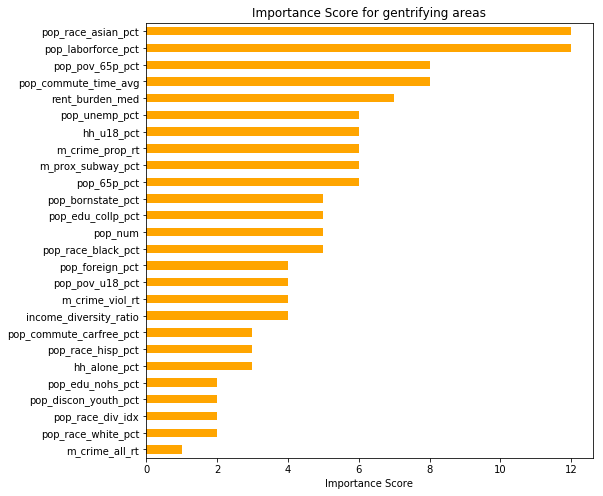

In [46]:
feat_imp1 = pd.Series(model1.get_booster().get_fscore()).sort_values(ascending = True)
feat_imp1.plot(kind = 'barh', title = 'Feature Importances', figsize = (8,8), color = 'orange')
plt.xlabel('Importance Score')
plt.title('Importance Score for gentrifying areas')
plt.show()

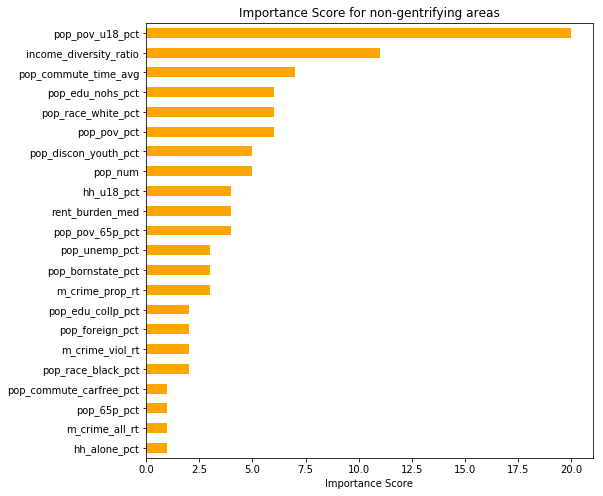

In [47]:
feat_imp2 = pd.Series(model2.get_booster().get_fscore()).sort_values(ascending = True)
feat_imp2.plot(kind = 'barh', title = 'Feature Importances', figsize = (8,8), color = 'orange')
plt.xlabel('Importance Score')
plt.title('Importance Score for non-gentrifying areas')
plt.show()

#### Step 3.2 Comparing the restaurant variables

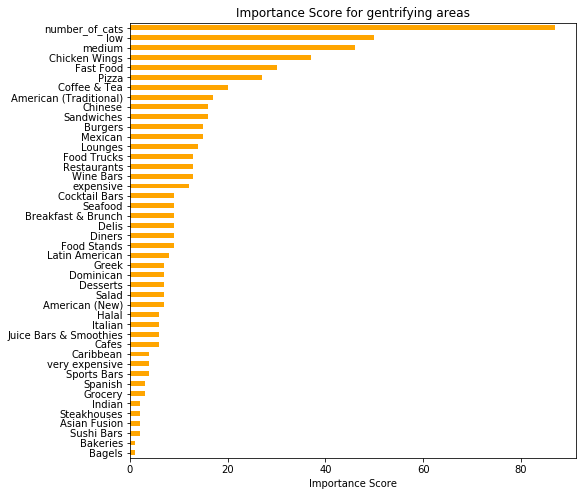

In [48]:
feat_imp3 = pd.Series(model3.get_booster().get_fscore()).sort_values(ascending = True)
feat_imp3.plot(kind = 'barh', title = 'Feature Importances', figsize = (8,8), color = 'orange')
plt.xlabel('Importance Score')
plt.title('Importance Score for gentrifying areas')
plt.show()

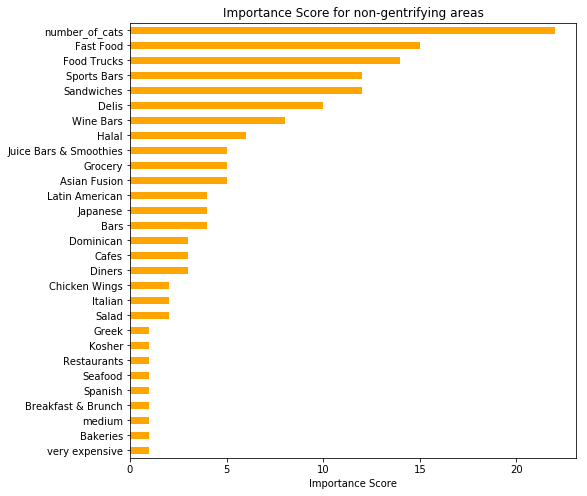

In [49]:
feat_imp4 = pd.Series(model4.get_booster().get_fscore()).sort_values(ascending = True)
feat_imp4.plot(kind = 'barh', title = 'Feature Importances', figsize = (8,8), color = 'orange')
plt.xlabel('Importance Score')
plt.title('Importance Score for non-gentrifying areas')
plt.show()

### Step 4. Get the SHAP values to quantify how the predictors affect the popularity

For gentrifying areas:

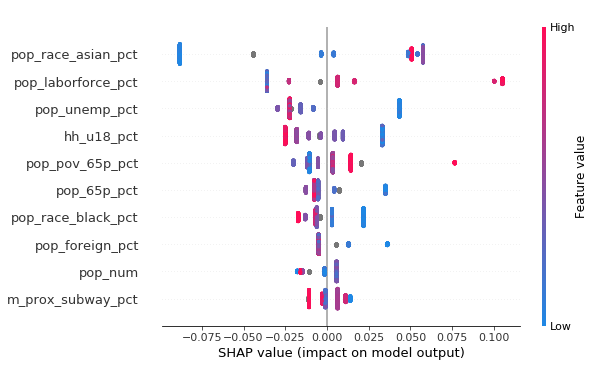

In [50]:
shap_values1 = shap.TreeExplainer(model1).shap_values(X_gentri)
shap.summary_plot(shap_values1, X_gentri, max_display=10)

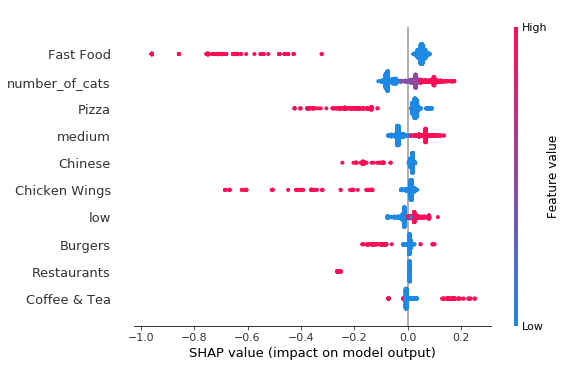

In [52]:
shap_values3 = shap.TreeExplainer(model3).shap_values(X_gentri3)
shap.summary_plot(shap_values3, X_gentri3, max_display=10)

For non-gentrifying areas:

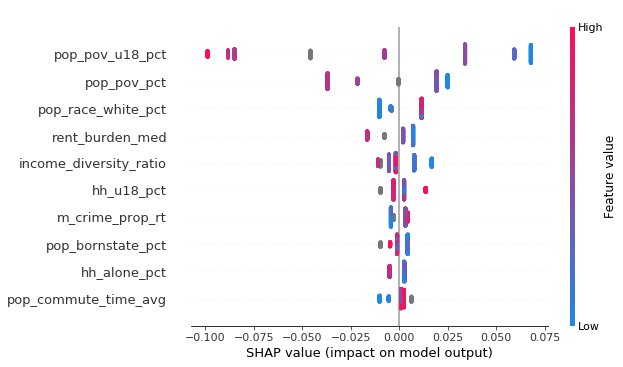

In [51]:
shap_values2 = shap.TreeExplainer(model2).shap_values(X_nongen)
shap.summary_plot(shap_values2, X_nongen, max_display=10)

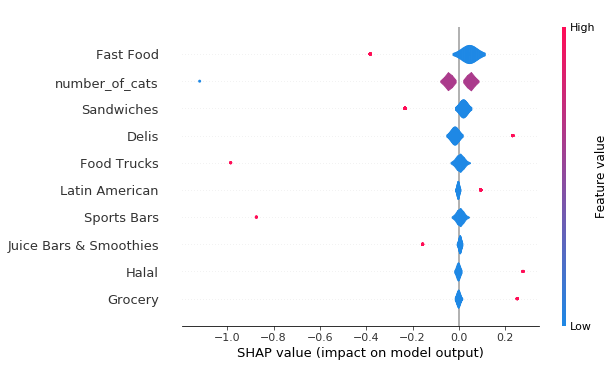

In [62]:
shap_values4 = shap.TreeExplainer(model4).shap_values(X_nongen3)
shap.summary_plot(shap_values4, X_nongen3, plot_type="violin", max_display=10)
# ind = [abs(i) <= 0.009 for i in list(map(np.mean, shap_values4))]
# shap.summary_plot(shap_values4[ind], X_nongen3[ind], plot_type="violin", max_display=10)

Export the SHAP values

In [76]:
pd.DataFrame(shap_values1, columns=X_gentri.columns).to_csv('../output/gentri_shap_demo.csv', index=False)
pd.DataFrame(shap_values3, columns=X_gentri3.columns).to_csv('../output/gentri_shap_restau.csv', index=False)
pd.DataFrame(shap_values2, columns=X_nongen.columns).to_csv('../output/nongen_shap_demo.csv', index=False)
pd.DataFrame(shap_values4, columns=X_nongen3.columns).to_csv('../output/nongen_shap_restau.csv', index=False)

### Step 5. Prepara data for Shiny

In [95]:
df_gentri = df_gentri_raw[['id','name','price','zip_code','latitude','longitude','rating_adj']]
df_nongen = df_nongen_raw[['id','name','price','zip_code','latitude','longitude','rating_adj']]
df_overla = df_overla_raw[['id','name','price','zip_code','latitude','longitude','rating_adj']]

In [96]:
# merge restaurant data, demographic data, and the category information
df_gentri_all = pd.merge(df_gentri, demo_gentri, how='left', left_on=['zip_code'], right_on = ['ZipCode'])
df_nongen_all = pd.merge(df_nongen, demo_nongen, how='left', left_on=['zip_code'], right_on = ['ZipCode'])
df_overla_all = pd.merge(demo_overla, df_overla, how='left', left_on=['id'], right_on = ['id'])
df_overla_all = df_overla_all.drop_duplicates(subset='id', keep="last")

data_gentri = pd.merge(df_gentri_all, catego_gentri, left_index=True, right_index=True)
data_gentri = data_gentri.drop(['ZipCode','puma10','puma_id','class'], axis=1)
data_nongen = pd.merge(df_nongen_all, catego_nongen, left_index=True, right_index=True)
data_nongen = data_nongen.drop(['ZipCode','puma10','puma_id','class'], axis=1)
data_overla = pd.merge(df_overla_all, catego_overla, left_index=True, right_index=True)

# assign the restaurants in the overlapped areas to gentrifying and non-gentrifying
gentri_add = data_overla[data_overla['class'] == 1]
gentri_add = gentri_add.drop(['zip_code', 'class'], axis=1)
nongen_add = data_overla[data_overla['class'] == 2]
nongen_add = nongen_add.drop(['zip_code', 'class'], axis=1)
frames = [data_gentri, gentri_add]
data_gentri_all = pd.concat(frames)
frames = [data_nongen, nongen_add]
data_nongen_all = pd.concat(frames)

data_gentri_price = data_gentri_all['price']
dummies_gentri = pd.get_dummies(data_gentri_price)
dummies_gentri.columns = ['low', 'medium', 'expensive', 'very expensive']
data_gentri_all = pd.concat([data_gentri_all, dummies_gentri], axis = 1).drop(['price'], axis=1)

data_nongen_price = data_nongen_all['price']
dummies_nongen = pd.get_dummies(data_nongen_price)
dummies_nongen.columns = ['low', 'medium', 'expensive', 'very expensive']
data_nongen_all = pd.concat([data_nongen_all, dummies_nongen], axis = 1).drop(['price'], axis=1)

In [99]:
data_nongen_output = data_nongen_all[['id','name','latitude','longitude','zip_code','puma_name','rating_adj',
       'American (New)', 'American (Traditional)', 'Asian Fusion', 'Bagels','Bakeries', 'Bars', 'Breakfast & Brunch',
       'Burgers', 'Cafes','Caribbean', 'Chicken Wings', 'Chinese', 'Cocktail Bars','Coffee & Tea', 'Delis', 
       'Desserts', 'Diners', 'Dominican', 'Fast Food','Food Stands', 'Food Trucks', 'Greek', 'Grocery', 'Halal',
       'Indian','Italian', 'Japanese', 'Juice Bars & Smoothies', 'Kosher','Latin American', 'Lounges', 'Mediterranean',
       'Mexican', 'Pizza','Restaurants', 'Salad', 'Sandwiches', 'Seafood', 'Soul Food', 'Spanish','Sports Bars', 
       'Steakhouses', 'Sushi Bars', 'Thai', 'Wine Bars','number_of_cats',
       'low', 'medium', 'expensive', 'very expensive',
       'hh_alone_pct', 'hh_u18_pct', 'income_diversity_ratio', 'm_crime_all_rt', 'm_crime_prop_rt', 'm_crime_viol_rt',
       'm_prox_subway_pct',  'pop_65p_pct','pop_bornstate_pct', 'pop_commute_carfree_pct', 'pop_commute_time_avg',
       'pop_discon_youth_pct', 'pop_edu_collp_pct', 'pop_edu_nohs_pct','pop_foreign_pct', 'pop_laborforce_pct', 
       'pop_num', 'pop_pov_65p_pct','pop_pov_pct', 'pop_pov_u18_pct', 'pop_race_asian_pct','pop_race_black_pct', 
       'pop_race_div_idx', 'pop_race_hisp_pct','pop_race_white_pct', 'pop_unemp_pct', 'rent_burden_med']]

data_gentri_output = data_gentri_all[['id','name','latitude','longitude','zip_code','puma_name','rating_adj',
       'American (New)', 'American (Traditional)', 'Asian Fusion', 'Bagels','Bakeries', 'Bars', 'Breakfast & Brunch',
       'Burgers', 'Cafes','Caribbean', 'Chicken Wings', 'Chinese', 'Cocktail Bars','Coffee & Tea', 'Delis', 
       'Desserts', 'Diners', 'Dominican', 'Fast Food','Food Stands', 'Food Trucks', 'Greek', 'Grocery', 'Halal',
       'Indian','Italian', 'Japanese', 'Juice Bars & Smoothies', 'Kosher','Latin American', 'Lounges', 'Mediterranean',
       'Mexican', 'Pizza','Restaurants', 'Salad', 'Sandwiches', 'Seafood', 'Soul Food', 'Spanish','Sports Bars', 
       'Steakhouses', 'Sushi Bars', 'Thai', 'Wine Bars','number_of_cats',
       'low', 'medium', 'expensive', 'very expensive',
       'hh_alone_pct', 'hh_u18_pct', 'income_diversity_ratio', 'm_crime_all_rt', 'm_crime_prop_rt', 'm_crime_viol_rt',
       'm_prox_subway_pct',  'pop_65p_pct','pop_bornstate_pct', 'pop_commute_carfree_pct', 'pop_commute_time_avg',
       'pop_discon_youth_pct', 'pop_edu_collp_pct', 'pop_edu_nohs_pct','pop_foreign_pct', 'pop_laborforce_pct', 
       'pop_num', 'pop_pov_65p_pct','pop_pov_pct', 'pop_pov_u18_pct', 'pop_race_asian_pct','pop_race_black_pct', 
       'pop_race_div_idx', 'pop_race_hisp_pct','pop_race_white_pct', 'pop_unemp_pct', 'rent_burden_med']]

In [101]:
data_gentri_output.to_csv('../output/gentri_data.csv', index=False)
data_nongen_output.to_csv('../output/nongen_data.csv', index=False)